<a href="https://colab.research.google.com/github/grosetta/rdkit_study/blob/main/%E5%88%86%E5%AD%90%E7%B1%BB%E8%8D%AF%E6%80%A7%E5%8F%AF%E8%A7%86%E5%8C%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#文件头代码
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.insert(0,"/content/gdrive/My Drive/Colab Notebooks/python_package/")

Mounted at /content/gdrive


# 模块导入

In [3]:
import pandas as pd
import numpy as np
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import BRICS
print(rdBase.rdkitVersion)

2022.09.4


In [4]:
# 定义计算分子Gasteiger电荷
def get_num_posotive_charged_atoms(mol):
  #返回正负电荷原子数
    mol_h = Chem.AddHs(mol)
    Chem.rdPartialCharges.ComputeGasteigerCharges(mol_h)
     
    positive = 0
    negative = 0
     
    for atom in mol_h.GetAtoms():
        if float(atom.GetProp('_GasteigerCharge')) >= 0:
            positive += 1
        else:
            negative += 1
     
    return positive
def get_num_negative_charged_atoms(mol):
  #返回正负电荷原子数
    mol_h = Chem.AddHs(mol)
    Chem.rdPartialCharges.ComputeGasteigerCharges(mol_h)
     
    positive = 0
    negative = 0
     
    for atom in mol_h.GetAtoms():
        if float(atom.GetProp('_GasteigerCharge')) >= 0:
            positive += 1
        else:
            negative += 1
     
    return negative
# 定义计算环的数量
def get_assembled_ring(mol):
    ring_info = mol.GetRingInfo()
    num_ring = ring_info.NumRings()
    ring_atoms = ring_info.AtomRings()
    num_assembled = 0
     
    for i in range(num_ring):
        for j in range(i+1, num_ring):
            x = set(ring_atoms[i])
            y = set(ring_atoms[j])
            if not x.intersection(y): 
                for x_id in x:
                    x_atom = mol.GetAtomWithIdx(x_id)
                    neighbors = [k.GetIdx() for k in x_atom.GetNeighbors()]
                    for x_n in neighbors:
                        if x_n in y: 
                            num_assembled += 1
     
    return num_assembled

# 计算不对成碳原子数
def get_num_stereocenters(mol):
    return AllChem.CalcNumAtomStereoCenters(mol) + AllChem.CalcNumUnspecifiedAtomStereoCenters(mol)

# 定义计算其他化学描述符的函数
def calc_descriptors(dataframe):
    dataframe['MW'] = dataframe.ROMol.map(Descriptors.MolWt)
    dataframe['PSA'] = dataframe.ROMol.map(Descriptors.TPSA)
    dataframe['n_atoms'] = dataframe.ROMol.map(lambda x: x.GetNumAtoms())
    dataframe['n_positive']= dataframe.ROMol.map(get_num_posotive_charged_atoms)
    dataframe['_n_negative'] = dataframe.ROMol.map(get_num_negative_charged_atoms)
    dataframe['n_rot_bonds'] = dataframe.ROMol.map(Descriptors.NumRotatableBonds)
    dataframe['n_rings'] = dataframe.ROMol.map(AllChem.CalcNumRings)
    dataframe['n_ar_rings'] = dataframe.ROMol.map(Descriptors.NumAromaticRings)
    dataframe['n_ring_asmbl'] = dataframe.ROMol.map(get_assembled_ring)
    dataframe['n_stereo'] = dataframe.ROMol.map(get_num_stereocenters)
    dataframe['n_HBA'] = dataframe.ROMol.map(Descriptors.NumHAcceptors)
    dataframe['n_HBD'] = dataframe.ROMol.map(Descriptors.NumHDonors)
    dataframe['Fsp3'] = dataframe.ROMol.map(Descriptors.FractionCSP3)
    dataframe['logP'] = dataframe.ROMol.map(Descriptors.MolLogP)



# FDA批准药物

In [62]:
#df = PandasTools.LoadSDF('/content/gdrive/MyDrive/data/3D structures.sdf', removeHs=True)
#筛选批准的药物分子
df.DRUG_GROUPS_copy = df.DRUG_GROUPS
df_approved = df.query('DRUG_GROUPS.str.contains("approved")', engine='python')
df_disapproved = df.query('DRUG_GROUPS == "investigational"', engine='python')  #,DRUG_GROUPS.isin(["investigational"]) "illicit","experimental"
#calc_descriptors(df_approved)
print('FDA数据库总分子数：',len(df.ROMol)) 
print('FDA批准的药物数：',len(df_approved))
print('FDA尚未批准的药物数：',len(df_disapproved)) 

FDA数据库总分子数： 9335
FDA批准的药物数： 2006
FDA尚未批准的药物数： 2136


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
descs = ['MW', 'PSA', 'n_atoms', 'n_positive', '_n_negative', 'n_rot_bonds',
       'n_rings', 'n_ar_rings', 'n_ring_asmbl', 'n_stereo', 'n_HBA', 'n_HBD',
       'Fsp3', 'logP']
 
scalar = StandardScaler()
scalar.fit(df_approved[descs])
df_std = scalar.transform(df_approved[descs])
pca = PCA(n_components=2)
pca.fit(df_std)
df_std_trans = pca.transform(df_std)

# 自己的分子

In [ ]:
df_my = PandasTools.LoadSDF('/content/gdrive/MyDrive/data/my_mol.sdf', removeHs=True)
calc_descriptors(df_my)
scalar.fit(df_my[descs])
df_std2 = scalar.transform(df_my[descs])
pca = PCA(n_components=2)
pca.fit(df_std2)
df_std_trans2 = pca.transform(df_std2)

# 绘图

array([[ 2.49850789,  0.42574994],
       [ 1.9318225 , -0.46367205],
       [-4.43033038,  0.03792211]])

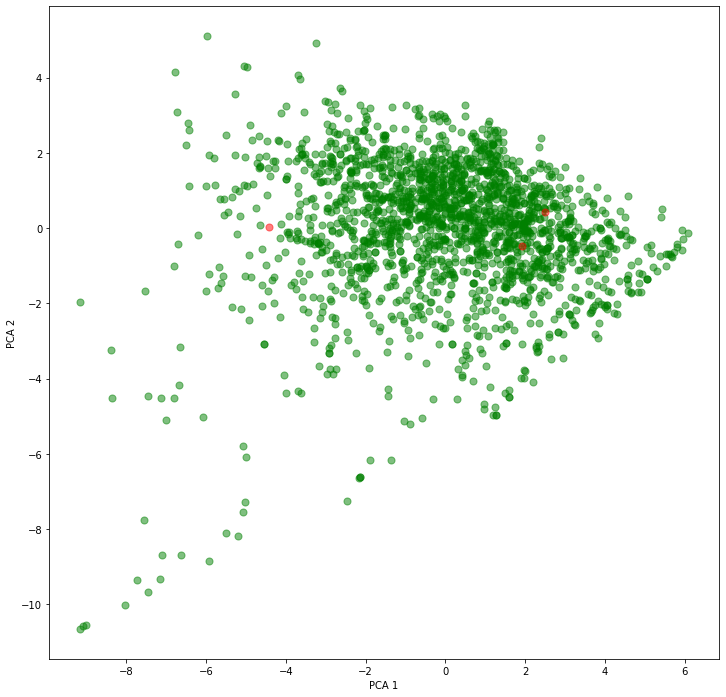

In [ ]:
# 可视化
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.scatter(-df_std_trans[:,0], -df_std_trans[:,1], s=50, alpha=0.5, c='g')
ax.scatter(-df_std_trans2[:,0], -df_std_trans2[:,1], s=50, alpha=0.5, c='r')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
 
 
np.cumsum(pca.explained_variance_ratio_)
-df_std_trans2

# 将approved和未批准的药物分子分别绘图(为卷积神经网络准备)

In [51]:
approved_drug_list = list(df_approved.ROMol)
i=0
for mol in approved_drug_list:
  i+=1
  img = Draw.MolToImage(mol,size=(256,256))
  img.save('/content/gdrive/MyDrive/data/approved_pic/approved_{}.jpg'.format(i))

In [ ]:
#!rm /content/gdrive/MyDrive/data/approved_pic/*

In [63]:
disapproved_drug_list = list(df_disapproved.ROMol)
i=0
for mol in disapproved_drug_list:
  i+=1
  img = Draw.MolToImage(mol,size=(256,256))
  img.save('/content/gdrive/MyDrive/data/disapproved_pic/disapproved_{}.jpg'.format(i))

In [61]:
#!rm /content/gdrive/MyDrive/data/disapproved_pic/*